In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif
import src.utils.sequence as utils

import scipy as sp
from matplotlib import pyplot as plt

# import wandb # This is optional 
# wandb.login(host = "https://genentech.wandb.io" )

/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load pre-trained model 

In [2]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/MPRA-dataset:v2/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    checkpoint_path = '../../save_models/hepg2_continuous/V2/-1_4-lr=1e-3/_2024.07.21_15.05.16/diffusion_epoch=052-average-loss=0.31.ckpt'
    time_schedule = 'artifacts/MPRA-dataset:v2/time_dependent.npz'
config = ModelParameters() 

DEVICE = "cuda:4"

In [3]:
original_model = lightning_dif.load_from_checkpoint(
        checkpoint_path=config.checkpoint_path, 
        weight_file=config.diffusion_weights_file, 
        time_schedule=config.time_schedule, 
        augment=False,
        continuous=True,
        y_low=-4.0,
        y_high=10.0
    )

original_model = original_model.model
original_model.cuda(device = DEVICE)

AugmentedScoreNet_Continuous(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), p

In [7]:
# Load the checkpoint
checkpoint = torch.load(config.checkpoint_path, map_location='cpu')
# print(checkpoint['state_dict'].keys())

# Create the model instance
lightning_dif_model = lightning_dif(
    weight_file=config.diffusion_weights_file,
    time_schedule=config.time_schedule,
    augment=True,
    continuous=True,
    y_low=-4.0,
    y_high=10.0
)

# Load the state dictionary
model_dict = lightning_dif_model.state_dict()


for (k, v) in checkpoint['state_dict'].items():
    model_dict[k] = v # shoud miss: 'model.additional_embed.0.W', 'model.additional_embed.1.bias', 'model.additional_embed.1.weight'

lightning_dif_model.load_state_dict(model_dict)

score_model = lightning_dif_model.model
score_model.cuda(device=DEVICE) # Move the model to the GPU

score_model.embed_class.requires_grad_(False)
score_model.embed_class.eval()

assert score_model.additional_embed[1].weight.requires_grad == True

In [9]:
# Load Reward model
from grelu.lightning import LightningModel

# reward_model = LightningModel.load_from_checkpoint('../../save_models/classifiers/k562_3class.ckpt')
reward_model = LightningModel.load_from_checkpoint(
    "../../save_models/eval_reward_models/hepg2_regressor.ckpt"
)

reward_model.eval()
reward_model.to(DEVICE)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [10]:
def new_reward_model(x):
    x = torch.nn.functional.softmax(x /0.1, -1) # x: [128, 50, 4]
    seq = torch.transpose(x, 1, 2) # seq: [128, 4, 50]
    return reward_model(seq)

: 

In [21]:
from src.model import ddsm_fine_tune  as fine_tune

save_name = "log_RL-condition_continuous_v1/"

loss_curves, eval_curves = fine_tune.fine_tuning(
        score_model, 
        new_reward_model, 
        [new_reward_model], 
        original_model,
        learning_rate=1e-3, 
        num_epoch=500, 
        length=50, 
        num_steps=50, 
        accmu=4, 
        gradient_start=45,
        batch_size=128,
        save_name=save_name, 
        entropy_coff=0.0,  
        device=DEVICE
    )

100%|██████████| 50/50 [00:00<00:00, 71.94it/s]


3


100%|██████████| 50/50 [00:02<00:00, 22.95it/s]


-2.474318504333496


100%|██████████| 50/50 [00:00<00:00, 73.66it/s]


7


100%|██████████| 50/50 [00:01<00:00, 29.28it/s]


-2.484550714492798


100%|██████████| 50/50 [00:00<00:00, 70.08it/s]


11


100%|██████████| 50/50 [00:01<00:00, 29.11it/s]


-2.5439867973327637


100%|██████████| 50/50 [00:00<00:00, 69.51it/s]


15


100%|██████████| 50/50 [00:01<00:00, 29.82it/s]


-3.072998523712158


100%|██████████| 50/50 [00:00<00:00, 73.99it/s]


19


100%|██████████| 50/50 [00:01<00:00, 26.17it/s]


-3.763517379760742


100%|██████████| 50/50 [00:00<00:00, 72.47it/s]


23


100%|██████████| 50/50 [00:01<00:00, 29.77it/s]


-4.845568656921387


100%|██████████| 50/50 [00:00<00:00, 73.25it/s]


27


100%|██████████| 50/50 [00:01<00:00, 29.40it/s]


-3.783583402633667


 32%|███▏      | 16/50 [00:00<00:00, 72.83it/s]

# Evaluation 

In [ ]:
#### Load Fine-Tuned Model 
time_dependent_weights = torch.tensor(np.load(config.time_schedule)['x'])
score_finetuned_model = modeld.ScoreNet_Conditional(
    time_dependent_weights=torch.sqrt(time_dependent_weights),
    all_class_number=3
    ) 
score_finetuned_model.load_state_dict(
    torch.load("./log_RL-condition_v1/_499.pth")
    ) # Change here
score_finetuned_model.cuda(device=DEVICE) 


ScoreNet_Conditional(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(

In [ ]:
### Get Samples after Fine-tune models 

sampler = ddsm.Euler_Maruyama_sampler

allsamples_original = []
for t in range(5):
    samples=[]
    score_finetuned_model.eval()
    samples.append(
        sampler(score_finetuned_model,
                (50,4),
                batch_size=128,
                new_class = None,
                class_number = 1,
                strength = 10, 
                max_time=  4.0,
                min_time= 1.0/400,
                time_dilation=1,
                num_steps=100, 
                eps=1e-5,
                speed_balanced= True,
                device= DEVICE, 
                ).cpu().detach().numpy()
        )
    
    allsamples_original.append(samples)

100%|██████████| 100/100 [00:01<00:00, 60.58it/s]


In [ ]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

generated_samples = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples.append(reward_model(batch).detach().cpu() ) 

generated_samples = np.concatenate(generated_samples)

In [ ]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

allsamples_original = []
for t in range(5):
    samples=[]
    score_model.eval()
    samples.append(sampler(original_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

100%|██████████| 100/100 [00:01<00:00, 61.40it/s]


In [ ]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

In [ ]:
generated_samples_before = []
data_loader = torch.utils.data.DataLoader(
        allsamples.astype("float32"), 
        batch_size=128 , 
        num_workers=0
    )
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples_before.append(reward_model(batch).detach().cpu() ) 

generated_samples_before = np.concatenate(generated_samples_before)

<Figure size 8000x1000 with 0 Axes>

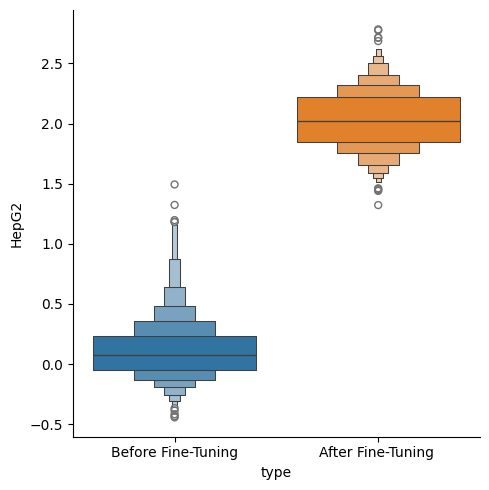

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(80, 10))

compare = np.concatenate((generated_samples_before[:,0], generated_samples[:,0]), axis= 0)

type1 = ['Before Fine-Tuning' for i in range(len(generated_samples_before[:,0] ))]
#type2 = ['Generated (Strong Sig)' for i in range(len(generated_samples[:,0] ))]
type3 = ['After Fine-Tuning ' for i in range(len(generated_samples[:,0]))]

type =   type1 +  type3
data_dict = {'type': type, 'K562': compare[:,0] }
plot_data = pd.DataFrame(data_dict)
fig = sns.catplot(data=plot_data, x = 'type', y =  'K562', hue="type", kind="boxen" )
sns.set_context("paper", rc={"figure.figsize": (80, 10)})
#fig.savefig("../media/RNA_output_high.png")



